$10,000$ MC replications ($s=10000$), $n=200, 400, 1000$,  
$E[Y|X] = \theta_0^2 X + \theta_0 X^2$, $\theta_0 = 5/4$, $X \sim N(\mu,1)$, $\mu=1$ in (a), $\mu=-1$ in (b).  
$\text{var}(Y|X)$ is constant.

Moments: with $\rho(X,\theta) = 2\theta X + X^2$,  
$(a): \mathbb{E}[\rho(X,\theta_0)(Y-\theta^2 X - \theta X^2)]$  
$(b): \mathbb{E}[\rho(X,\theta)(Y-\theta^2 X - \theta X^2)]$

Do GMM with initial values $-4, -2, 0, 2$ randomly.

In [1]:
#!pip install tikzplotlib

In [2]:
import numpy as np
from numba import njit,jit
import pandas as pd
from scipy import optimize
import sys
import matplotlib.pyplot as plt
import tikzplotlib

In [3]:
# DGP
@jit
def my_dgp(n, mu):
    """
    n = sample size, mu = 1 or -1.
    """
    theta_0 = 5/4
    X = np.random.normal(size=n, loc=mu, scale=1)
    if len(X.shape) == 1:
        X = X.reshape(n,1)
    U = np.random.normal(size=n, loc=0, scale=1) * X
    Y = (theta_0**2)*X + theta_0 * (X**2)
    
    return Y, X

# GMM
def my_gmm(Y,X, moment, init):
    """
    moment = 'a' or 'b'
    """
    n,_ = X.shape
    
    # moment
    rho = lambda X,theta: 2*theta*X + X**2
    moment_a = lambda Y,X,theta: rho(X, 5/4) * (Y - (theta**2)*X - theta*(X**2))
    moment_b = lambda Y,X,theta: rho(X, theta) * (Y - (theta**2)*X - theta*(X**2))
    if moment == 'a':
        mom=moment_a
    elif moment == 'b':
        mom=moment_b
    else:
        print("moment should be 'a' or 'b'")
                                                  
    # objective function
    def obj(theta):
        g = lambda theta: mom(Y,X, theta).mean()
        J = lambda theta: n*(g(theta)**2)
        
        theta1 = optimize.fmin(J, init, disp=False)
        e = mom(Y,X,theta1)
        omega = (e-e.mean()).T@(e-e.mean())/n  # centered
        
        obj = n * g(theta)**2 / omega
        return obj
    coef = optimize.fmin(obj, init, disp=False)
    return coef[0]

In [4]:
@njit
def _rho(X,theta):
    return 2*theta*X + X**2
@njit
def _moment_a(Y,X,theta):
    return _rho(X, 5/4) * (Y - (theta**2)*X - theta*(X**2))
@njit
def _moment_b(Y,X,theta):
    return _rho(X, theta) * (Y - (theta**2)*X - theta*(X**2))

def my_gmm2(Y,X, moment, init):
    """
    moment = 'a' or 'b'
    """
    n,_ = X.shape
    
    if moment == 'a':
        mom=_moment_a
    elif moment == 'b':
        mom=_moment_b
    else:
        print("moment should be 'a' or 'b'")
                                                  
    # objective function
    def obj(theta):
        # 1S
        g = np.mean(mom(Y,X, theta))
        J = lambda theta: n*(g**2)

        theta1 = optimize.fmin(J, init, disp=False)
        e = mom(Y,X,theta1)
        omega = np.dot((e-np.mean(e)).reshape(-1),(e-np.mean(e)).reshape(-1))/n  # centered
        
        # obj
        obj = n * g**2 / omega
        return obj
    coef = optimize.fmin(obj, init, disp=False)
    return coef[0]

In [5]:
# JIT compile
Y,X = my_dgp(1000, 1)
my_gmm2(Y,X,'a',-1.25)
my_gmm2(Y,X,'b',-4)

/tmp/ipykernel_29553/212953200.py:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "my_dgp" failed type inference due to: Cannot unify array(float64, 1d, C) and array(float64, 2d, C) for 'X.2', defined at /tmp/ipykernel_29553/212953200.py (11)

File "../../../tmp/ipykernel_29553/212953200.py", line 11:
<source missing, REPL/exec in use?>

During: typing of assignment at /tmp/ipykernel_29553/212953200.py (11)

File "../../../tmp/ipykernel_29553/212953200.py", line 11:
<source missing, REPL/exec in use?>

  @jit
/opt/conda/lib/python3.7/site-packages/numba/core/object_mode_passes.py:152: NumbaWarning: Function "my_dgp" was compiled in object mode without forceobj=True.

File "../../../tmp/ipykernel_29553/212953200.py", line 2:
<source missing, REPL/exec in use?>

  state.func_ir.loc))
/opt/conda/lib/python3.7/site-packages/numba/core/object_mode_passes.py:162: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to t

-2.9244140624999986

In [6]:
def my_simulation(moment,
                  num_sim=10000,
                  sample_size = [200,400,1000],
                  init=[-4,-2,0,2]):    
    if moment == 'a':
        mu = -1
    elif moment == 'b':
        mu = 1
    else:
        print("moment should be 'a' or 'b'")
    
    result = []
    for _,n in enumerate(sample_size):
        result_n = []
        for s in range(num_sim):
            sys.stdout.write("\r({}), n:{}, s:{}/{}          ".format(moment,n,s+1,num_sim))
            sys.stdout.flush()
            np.random.seed(s)
            Y,X = my_dgp(n, mu)
            theta0 = init[np.random.randint(len(init))]
            thetahat = my_gmm2(Y,X,moment,theta0)
            result_n.append(thetahat)
        result.append(np.array(result_n))
    df = pd.DataFrame({"n={}".format(sample_size[i]):result[i] for i in range(len(result))})
    df.to_csv("result_{}.csv".format(moment), index=False)
    print("\nthe result saved in result_{}.csv".format(moment))
    return df

#result_a = my_simulation('a', 30, [20,40,100])

In [7]:
df_a = my_simulation('a')

(a), n:1000, s:10000/10000          
the result saved in result_a.csv


In [8]:
df_b = my_simulation('b')

(b), n:1000, s:10000/10000          
the result saved in result_b.csv


In [9]:
print("done")

done


In [10]:
df_a = pd.read_csv("result_a.csv")
df_b = pd.read_csv("result_b.csv")

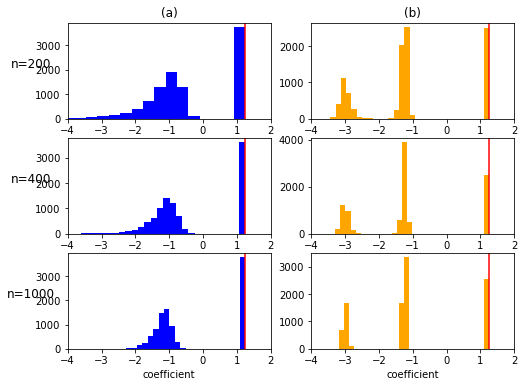

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2)

for i in range(3):
    ax_a = axes.flatten()[2*i]
    ax_b = axes.flatten()[2*i+1]
    
    ax_a.hist(df_a.iloc[:,i],color='blue', bins=30)
    ax_a.set_xlim(-4,2)
    ax_a.set_xlabel('coefficient')
    ax_a.set_xticks([-4,-3,-2,-1,0,1,2])
    ax_a.axvline(1.25, color='red')

    ax_b.hist(df_b.iloc[:,i],color='orange', bins=30)
    ax_b.set_xlim(-4,2)
    ax_b.set_xlabel('coefficient')
    ax_b.set_xticks([-4,-3,-2,-1,0,1,2])
    ax_b.axvline(1.25, color='red')
    
# col, row header
cols = ['(a)', '(b)']
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

rows = ['n=200', 'n=400', 'n=1000']
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')

fig.set_figheight(6)
fig.set_figwidth(8)
tikzplotlib.save("test.tex")